In [ ]:
import torch
from dataset import MNIST
from clip import CLIP
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import multiprocessing

def main():
    DEVICE='cuda' if torch.cuda.is_available() else 'cpu'   # 设备

    dataset=MNIST() # 数据集

    model=CLIP().to(DEVICE) # 模型

    optimzer=torch.optim.Adam(model.parameters(),lr=1e-4)   # 优化器

    '''
        训练模型
    '''
    ITER_BATCH_COUNT=100000    # 迭代次数
    BATCH_SIZE=64   # 从batch内选出10个不一样的数字
    TARGET_COUNT=10 # 共10种数字

    # 修改worker数量为0可以避免多进程问题
    dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)    # 数据加载器

    for i in range(ITER_BATCH_COUNT):
        while True:
            imgs,labels=next(iter(dataloader))
            if torch.unique(labels).shape[0]<TARGET_COUNT:  # 未覆盖10种数字
                continue
            # 挑选出10个数字
            target=set()
            indexes=[]
            for j in range(BATCH_SIZE):
                if labels[j].item() in target:
                    continue
                target.add(labels[j].item())
                indexes.append(j)
                if len(target)==TARGET_COUNT:
                    break
            imgs=imgs[indexes]
            labels=labels[indexes]
            break

        ### ====== TODO: TASK2: 完成模型损失函数计算的代码（BEGIN）

        # 通过模型获取相似度矩阵
        logits = model(imgs.to(DEVICE), labels.to(DEVICE))

        # 对比学习中，第i个图像应该与第i个文本匹配
        labels_one_hot = torch.arange(TARGET_COUNT, device=DEVICE)

        # 计算双向对比损失（图像到文本 + 文本到图像）
        loss = (F.cross_entropy(logits, labels_one_hot) +
                F.cross_entropy(logits.t(), labels_one_hot)) / 2

        ### ====== TODO: TASK 2: 完成模型损失函数计算的代码（END）

        optimzer.zero_grad()
        loss.backward()
        optimzer.step()
        if i%1000==0:
            print('iter:{},loss:{}'.format(i,loss))
            torch.save(model.state_dict(),'.model.pth')
            os.replace('.model.pth','model.pth')

# 重要！添加程序入口保护
if __name__ == '__main__':
    multiprocessing.freeze_support()  # 在Windows上需要
    main()

100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 13.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 74.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.05MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


iter:0,loss:2.299030303955078
iter:1000,loss:1.5611913204193115
iter:2000,loss:1.5876917839050293
iter:3000,loss:1.5171871185302734
iter:4000,loss:1.4702074527740479
iter:5000,loss:1.467367172241211
iter:6000,loss:1.4978662729263306
iter:7000,loss:1.4760022163391113
iter:8000,loss:1.4784413576126099
iter:9000,loss:1.5143699645996094
iter:10000,loss:1.4265239238739014
iter:11000,loss:1.518340826034546
iter:12000,loss:1.4527642726898193
iter:13000,loss:1.4745798110961914
iter:14000,loss:1.5628423690795898
iter:15000,loss:1.5322625637054443
iter:16000,loss:1.4223910570144653
iter:17000,loss:1.4258902072906494
iter:18000,loss:1.4090840816497803
iter:19000,loss:1.5369582176208496
iter:20000,loss:1.4194860458374023
iter:21000,loss:1.487403392791748
iter:22000,loss:1.5164856910705566
iter:23000,loss:1.4058802127838135
iter:24000,loss:1.4452910423278809
iter:25000,loss:1.398712158203125
iter:26000,loss:1.476130723953247
iter:27000,loss:1.4075860977172852
iter:28000,loss:1.4022513628005981
iter

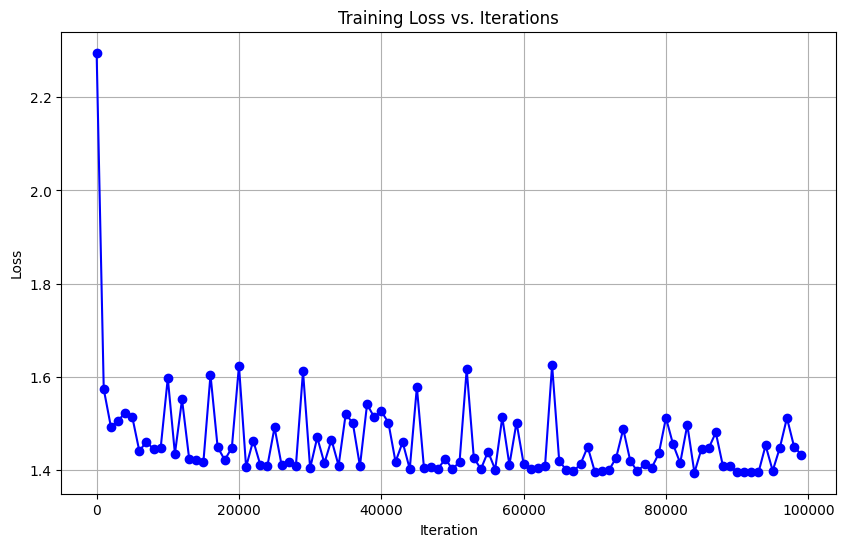

Initial loss: 2.2952487468719482
Final loss: 1.433734655380249
Loss reduction: 0.8615140914916992 (37.53%)


In [6]:
import re
import numpy as np
import os
import matplotlib.pyplot as plt

# Option 1: Read loss values from a log file (if available)
def read_loss_from_file(log_file_path):
    iterations = []
    losses = []
    
    try:
        with open(log_file_path, 'r') as f:
            for line in f:
                if 'iter:' in line and 'loss:' in line:
                    match = re.search(r'iter:(\d+),loss:(\d+\.\d+)', line)
                    if match:
                        iterations.append(int(match.group(1)))
                        losses.append(float(match.group(2)))
        return iterations, losses
    except FileNotFoundError:
        print(f"Log file {log_file_path} not found.")
        return [], []


# Parse the loss values
iterations, losses = read_loss_from_file(os.path.join('output', 'training_log.txt'))

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('output/training_loss.pdf')
plt.show()

# Print some statistics
if losses:
    print(f"Initial loss: {losses[0]}")
    print(f"Final loss: {losses[-1]}")
    print(f"Loss reduction: {losses[0] - losses[-1]} ({(1 - losses[-1]/losses[0])*100:.2f}%)")